# <center><span> Microtom co-expression analysis </span> </center>
## <center> ABE 4662: Project 3 </center>
### <center> Bryce Askey </center>
### <center> 12/17/2020 </center>

### Bringing it all together:
In Project 1, I used a Pearson Correlation Coefficient (PCC) method to construct a simple gene network from gene expression data. In Project 2, I applied k-means clustering to separate metabolites into clusters based on their pattern of accumulation across the 20 tissue samples collected. Because of the close interplay between a plant's chemical and transcriptional status, these gene expression and metabolite accumulation datasets can be integrated together to form a co-expression network. This should allow for identification of not only genes acting in metabolite biosynthesis, but also those are directly and indirectly regulated by the chemical status of the plant. Genes which play a role in upstream signaling for chemical shifts (e.g. hormone receptors) should also be highlighted by the network.

<img src="fig1.PNG" width="800"><br/>
Illustration of tissue samples taken to generate gene expression dataset for MicroTom (Li et al., 2020).

For example, consider a plant hormone, such as indole-3-acetic acid (aka auxin). Auxin is known to promote plant growth by signaling for stem and root elongation. In a co-expression network, auxin should form connections with both auxin biosyntheis and auxin response genes. Because auxin is synthesized in response to a variety of abiotic triggers (e.g. light and gravity), auxin should also form connections with receptors acting in these pathways. With this approach, a metabolite can be placed into biological context by considering genes acting upstream, in its biosynthesis, and downstream. This allows for us to develop an understanding of the bidirectional communication between gene expression and metabolite accumulation.

To develop this co-expression network, I will combine methods that I've previously presented in Projects 1 and 2. First, I will use Pearson's Correlation Coefficient (PCC) to correlate together metabolite accumulation and gene expression for the entire dataset. I will then apply filtering to randomly select a small subset of genes and metabolites which have significant associations. I'll log the most significant associations in this subset, and save that as a .csv file. To another .csv file, I'll also save information about the genes and metabolites in the subset, including the cluster to which each metabolite belongs (determined in Project 2). I'll apply another round of PCC to correlate the subset of genes against themselves to identify gene-gene interactions, similar to what I presented in Project 1. I'll save the most significant interactions to one more .csv file. Finally, I'll use the visNetwork library in R to merge together these .csv files, and draw an interactive co-expression network.

In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns; sns.set(rc={'figure.figsize':(8,8)})
import matplotlib.pyplot as plt

Load the gene expression and metabolite dataset from a .csv file, and create numpy arrays containing only expression/accumulation data (no metadata).

In [2]:
# Load gene expression dataset
exprData = pd.read_csv(filepath_or_buffer="C:/Users/bca08_000/Documents/Classes/ABE4662/project3/microtomGeneExpression.csv", header=2)
exprData = exprData.set_index("Gene")

# Load metabolite accumulation dataset
metData = pd.read_csv(filepath_or_buffer="C:/Users/bca08_000/Documents/Classes/ABE4662/project3/metaboliteData.csv")
metData = metData.set_index("Index")

# Create arrays with only data
exprDataArray = np.array(exprData.iloc[:, 5:exprData.shape[1]])
metDataArray = np.array(metData.iloc[:, 9:metData.shape[1]])

I'll apply the built-in PCC function from numpy to calculate gene-metabolite associations for all genes and metabolites. This step can take a while (10-30 mins!) so it's best to save the output into a .csv file which can be loaded when needed. Just as in the correlation matrix generated in Project 1, the values in this correlation matrix range between -1 and 1. A value of -1 represents a perfect negative correlation (e.g. concentration of metabolite increases while expression of gene decreases), and a value of 1 represents a perfect positive correlation (e.g. concentration of metabolite increases while expression of gene increases). Each row in the correlation matrix represents a metabolite, and each column a gene.

In [3]:
# Only needs to be run once!
# Creates a correlation matrix - each row represents a metabolite, and each column a gene.
metExprPCC = np.zeros(shape=(metDataArray.shape[0], exprDataArray.shape[0]))
for row in range(0, metExprPCC.shape[0]):
    for col in range(0, metExprPCC.shape[1]):
        metExprPCC[row, col] = np.corrcoef(metDataArray[row, :], exprDataArray[col, :])[1, 0]
metExprPCC = pd.DataFrame(data=metExprPCC, index=metData.index, columns=exprData.index)
metExprPCC.to_csv(path_or_buf="metExprPCC.csv")

If the gene-metabolite correlation matrix has already been generated, it can just be loaded from the .csv file. Let's take a look at a summary of the first 5 rows in the matrix dataframe to understand its format.

In [3]:
metExprPCC = pd.read_csv(filepath_or_buffer="metExprPCC.csv", header=0, index_col=0)
metExprPCC.head()

,Solyc00g005000.3,Solyc00g005040.3,Solyc00g005050.3,Solyc00g005080.2,Solyc00g005084.1,Solyc00g005092.1,Solyc00g005094.1,Solyc00g005096.1,Solyc00g005283.1,Solyc00g005285.1,...,Solyc12g100270.2,Solyc12g100280.2,Solyc12g100290.2,Solyc12g100300.2,Solyc12g100310.2,Solyc12g100320.2,Solyc12g100330.2,Solyc12g100340.1,Solyc12g100350.2,Solyc12g100353.1
Index,,,,,,,,,,,,,,,,,,,,,
pmf0352,0.168696,-0.333850,-0.845259,-0.160277,-0.408747,-0.670373,-0.741622,0.333407,0.111507,0.192361,...,0.198472,0.337041,0.489947,0.115577,-0.181466,-0.277947,0.052465,0.204832,-0.629037,-0.626489
pmf0460,0.080320,-0.074703,0.299804,-0.074845,-0.101833,-0.056876,-0.150638,-0.319255,0.158321,0.281524,...,-0.001114,-0.224629,-0.364234,-0.055220,-0.033868,0.239494,0.056852,-0.456422,-0.092262,-0.136223
pmf0467,0.443108,-0.275401,-0.817180,0.037065,-0.449597,-0.681630,-0.812287,0.482537,0.052964,0.204841,...,0.413191,0.441576,0.646637,0.323652,0.141302,-0.256575,0.356910,-0.147554,-0.516190,-0.611568
pmf0500,0.089431,0.188067,0.537824,0.044571,0.152067,0.240291,0.179934,-0.086927,-0.239185,-0.025567,...,-0.043223,-0.096421,-0.410833,0.020514,0.304776,0.243571,0.192239,-0.746861,0.282500,0.209129
pmf0422,0.387740,-0.307612,-0.845271,0.007802,-0.479407,-0.688224,-0.813529,0.432052,0.119791,0.249840,...,0.383608,0.459704,0.659916,0.293860,0.064772,-0.246879,0.300577,-0.047679,-0.546844,-0.634456


The correlations in the matrix that are most significant are the ones that are either closest to -1 or to 1. These significant correlations are most likely to represent an actual relationship between a gene and a metabolite. To determine the upper and lower cutoffs for significance, I'll calculate values corresponding to the 0.1 and 99.9 percentiles of all correlations in the matrix. I'll also create a histogram to illustrate what these cutoffs represent.

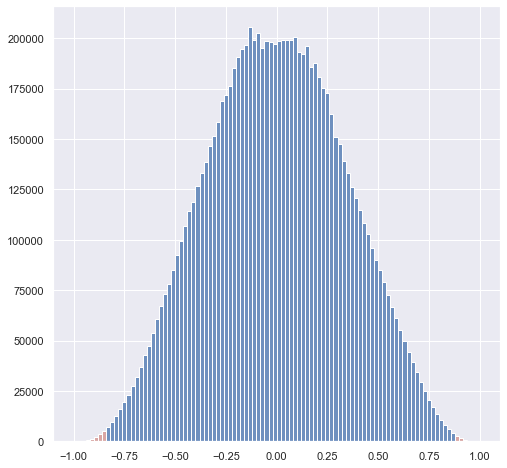

In [4]:
metExprList = (metExprPCC.to_numpy()).flatten()
lowCutoff = np.percentile(metExprList, 0.1)
highCutoff = np.percentile(metExprList, 99.9)

n, bins, patches = plt.hist(metExprList, bins=100, range=[-1, 1])
for c, p in zip(bins, patches):
    if c < lowCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
    elif c >= lowCutoff and c < highCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[0])
    else:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
plt.show()

To reduce the size of the dataset, I'll first randomly sample a set of genes and metabolites. I'll then filter this randomly selected set row-wise to remove any metabolites which have no significantly associated genes. Then, I'll filter the set column-wise to remove any genes which have no significantly associated metabolites. I'll also remove any filtered genes and metabolites from the original metData and exprData dataframes. The final result will be a much smaller and more manageable dataset which contains only genes and metabolites with signficant associations.

In [5]:
# Filter out any genes and metabolites which have no significant associations.
# First apply random sampling to reduce size of dataset.
metExprPCC = metExprPCC.sample(n=10).sample(n=3000, axis=1)
metabolitesToDrop = list(set(metData.index) - set(metExprPCC.index))
genesToDrop = list(set(exprData.index) - set(metExprPCC.columns))

# Then for significant metabolites: row-wise filtering.
for row in range(0, metExprPCC.shape[0]):
    if sum(metExprPCC.iloc[row, :] > highCutoff) == 0 and sum(metExprPCC.iloc[row, :] < lowCutoff) == 0:
        metabolitesToDrop.append(metExprPCC.index[row])
metExprPCC = metExprPCC.drop(metabolitesToDrop, axis=0, errors="ignore")
metData = metData.drop(metabolitesToDrop, axis=0) # also drop from metabolite dataframe

# Then for significant genes: column-wise filtering.
for col in range(0, metExprPCC.shape[1]):
    if sum(metExprPCC.iloc[:, col] > highCutoff) == 0 and sum(metExprPCC.iloc[:, col] < lowCutoff) == 0:
        genesToDrop.append(metExprPCC.columns[col])
metExprPCC = metExprPCC.drop(genesToDrop, axis=1, errors="ignore")
exprData = exprData.drop(genesToDrop, axis=0) # also drop from expression dataframe

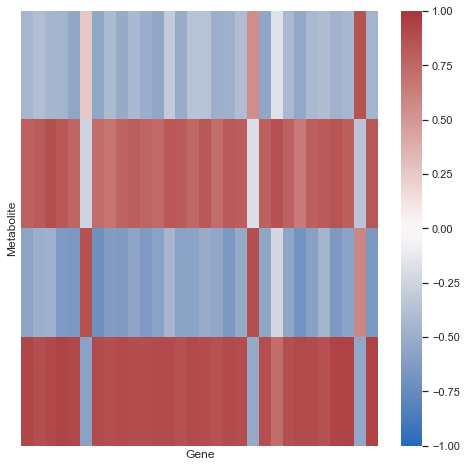

In [6]:
# Dataset is more manageable! Make a heatmap to see what we're working with
ax = sns.heatmap(metExprPCC, vmin=-1, vmax=1, cmap="vlag", xticklabels=False, yticklabels=False, square=False)
ax.set(xlabel="Gene", ylabel="Metabolite")
plt.show()

The metabolite accumulation and gene expression dataframes have been filtered to remove any genes/metabolites not included in the selected subset. I'll save these dataframes as .csv files into a folder that I've named "preprocessedData". These 2 files contain the "node" information for the network (aka info about each point in the network). Note that the "metData.csv" file will have the cluster information for the metabolites that was determined in Project 2.

In [7]:
# Save info about filtered genes and metabolites into separate .csv files
metData.to_csv(path_or_buf="preprocessedData/metData.csv")
exprData.to_csv(path_or_buf="preprocessedData/exprData.csv")

I'll also record the metabolite-gene associations that were most significant in the subset of data. To a dataframe, I'll enter the metabolite and gene involved in each significant association, as well whether the correlation was positive or negative. In network analysis, these significant associations which connect 2 nodes are usually referred to as "edges". I'll save this edge dataframe as a .csv to the same "preprocessedData" folder that the node info is saved in. 

In [8]:
# Create a dataframe with metabolite-genes edges and save for use later
metExprEdges = pd.DataFrame(columns=["Gene", "Metabolite", "Direction"])
for row in range(0, metExprPCC.shape[0]):
    for col in range(0, metExprPCC.shape[1]):
        if metExprPCC.iloc[row, col] > highCutoff:
            metExprEdges = metExprEdges.append({"Gene":metExprPCC.columns[col], "Metabolite":metExprPCC.index[row], "Direction":"+"}, ignore_index=True)
        elif metExprPCC.iloc[row, col] < lowCutoff:
            metExprEdges = metExprEdges.append({"Gene":metExprPCC.columns[col], "Metabolite":metExprPCC.index[row], "Direction":"-"}, ignore_index=True)
metExprEdges.to_csv(path_or_buf="preprocessedData/metExprEdges.csv")

To calculate gene-gene associations, a similar workflow as that applied in Project 1 will be used here. The only major difference is that I'll use numpy's built-in function for calculating PCC instead of creating a function myself.

In [9]:
# Create correlation matrix for gene-gene interactions
# Regenerate expression data array from filtered genes
exprDataArray = np.array(exprData.iloc[:, 5:exprData.shape[1]])
exprPCC = np.zeros(shape=(exprDataArray.shape[0], exprDataArray.shape[0]))
for row in range(0, exprPCC.shape[0]):
    for col in range(0, exprPCC.shape[1]):
        exprPCC[row, col] = np.corrcoef(exprDataArray[row, :], exprDataArray[col, :])[1, 0]
exprPCC = pd.DataFrame(data=exprPCC, index=exprData.index, columns=exprData.index)
exprPCC.head()

Gene,Solyc01g005140.3,Solyc01g065720.3,Solyc01g068500.3,Solyc01g099415.1,Solyc01g103440.3,Solyc02g064808.1,Solyc02g094510.3,Solyc03g007430.3,Solyc03g082730.1,Solyc03g097310.3,...,Solyc09g005100.3,Solyc09g066150.1,Solyc09g089660.3,Solyc09g092430.3,Solyc10g006960.2,Solyc10g007880.3,Solyc10g079050.2,Solyc10g086220.2,Solyc11g008380.2,Solyc12g019860.2
Gene,,,,,,,,,,,,,,,,,,,,,
Solyc01g005140.3,1.000000,0.943475,0.920186,0.877300,0.789572,0.800314,0.895592,0.876038,0.877869,0.846798,...,0.938635,0.906238,0.903600,-0.380688,0.859271,0.869777,0.821844,-0.407461,0.799956,0.819667
Solyc01g065720.3,0.943475,1.000000,0.976043,0.937107,0.904507,0.832647,0.946263,0.958050,0.899775,0.955879,...,0.962525,0.949677,0.943446,-0.498272,0.938715,0.916217,0.833741,-0.512913,0.927417,0.925458
Solyc01g068500.3,0.920186,0.976043,1.000000,0.951757,0.909268,0.830840,0.900612,0.931647,0.900401,0.916617,...,0.929939,0.956917,0.911099,-0.522737,0.960196,0.882574,0.848071,-0.532398,0.935794,0.893051
Solyc01g099415.1,0.877300,0.937107,0.951757,1.000000,0.829179,0.901332,0.911309,0.882601,0.935551,0.878095,...,0.912271,0.871040,0.937638,-0.537795,0.875976,0.901527,0.754381,-0.540116,0.871745,0.899549
Solyc01g103440.3,0.789572,0.904507,0.909268,0.829179,1.000000,0.736456,0.837354,0.906678,0.793185,0.910038,...,0.866784,0.911623,0.837430,-0.555002,0.915592,0.833481,0.800895,-0.499864,0.946633,0.895469


<AxesSubplot:xlabel='Gene', ylabel='Gene'>

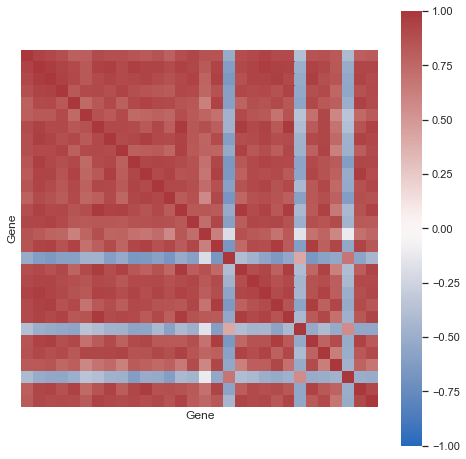

In [10]:
# Can also make a heatmap of this dataset
sns.heatmap(exprPCC, vmin=-1, vmax=1, cmap="vlag", xticklabels=False, yticklabels=False, square=True)

I'll calculate significant gene-gene associations by calculating correlations values at the 5th and 95th percentiles of all correlations.

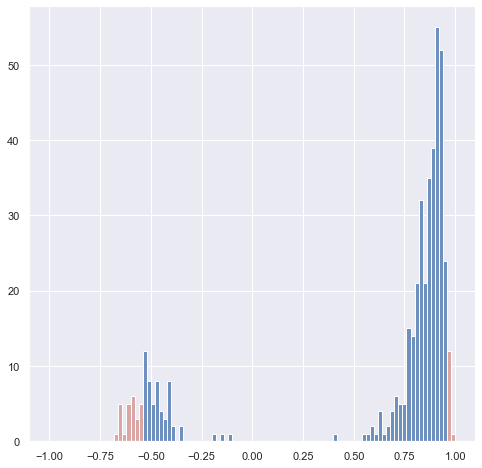

In [11]:
exprList = np.triu(exprPCC.to_numpy(), k=1)
exprList = exprList.flatten()
exprList = exprList[exprList!=0]

lowCutoff = np.percentile(exprList, 5)
highCutoff = np.percentile(exprList, 95)

n, bins, patches = plt.hist(exprList, bins=100, range=[-1, 1])
for c, p in zip(bins, patches):
    if c < lowCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
    elif c >= lowCutoff and c < highCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[0])
    else:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
plt.show()

I'll save any gene-gene association which fall above the upper threshold, or below the lower threshold. To a dataframe, I'll log the 2 genes involved in each association, as well as whether the correlation was positive or negative. I'll save this "edge" dataframe to the preprocessedData folder.

In [12]:
# Create a dataframe with gene-gene edges and save
upperExprPCC = pd.DataFrame(np.triu(exprPCC.to_numpy(), k=1), index=exprPCC.index, columns=exprPCC.columns)
exprEdges = pd.DataFrame(columns=["Gene1", "Gene2", "Direction"])
for row in range(0, upperExprPCC.shape[0]):
    for col in range(0, upperExprPCC.shape[1]):
        if upperExprPCC.iloc[row, col] > highCutoff:
            exprEdges = exprEdges.append({"Gene1":upperExprPCC.index[row], "Gene2":upperExprPCC.columns[col], "Direction":"+"}, ignore_index=True)
        elif upperExprPCC.iloc[row, col] < lowCutoff:
            exprEdges = exprEdges.append({"Gene1":upperExprPCC.index[row], "Gene2":upperExprPCC.columns[col], "Direction":"-"}, ignore_index=True)
exprEdges.to_csv(path_or_buf="preprocessedData/exprEdges.csv")